In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv


In [42]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
import urllib.request
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from gensim.models import Word2Vec
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,Input,SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow import keras
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [3]:
df = pd.read_csv('/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv')


In [4]:
df.sample(5)

,clean_text,category
142430,okay that enough let’ save this thread wins w...,1.0
136089,prime minister said that never claimed have co...,0.0
4095,this nyay lollipop took decades announce \npeo...,0.0
77698,pahle ground fir hawa fir space forget the gov...,0.0
10789,thought india was producing 450 jobs day turns...,-1.0


In [5]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [6]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])       
count_values_in_column(df,"category")

,Total,Percentage
category,,
1.0,72250,44.33
0.0,55213,33.88
-1.0,35510,21.79
NaN,7,0.00


Based on the analysis of the data:

1. **Positive Tweets**: Positive tweets make up more than 40% of the total tweets, indicating a significant proportion of positive sentiment in the dataset.

2. **Negative Tweets**: Negative tweets are relatively low in number, comprising only about 50% of the count compared to positive tweets. This suggests that negative sentiment is less prevalent in the dataset.

3. **Neutral Tweets**: Neutral tweets have a substantial count, falling between the counts of positive and negative tweets. They contribute significantly to the total tweet count, indicating a balanced distribution of sentiment between positive and negative tweets.

In [7]:
df_negative = df[df["category"]==-1]
df_positive = df[df["category"]==1]
df_neutral= df[df["category"]==0]

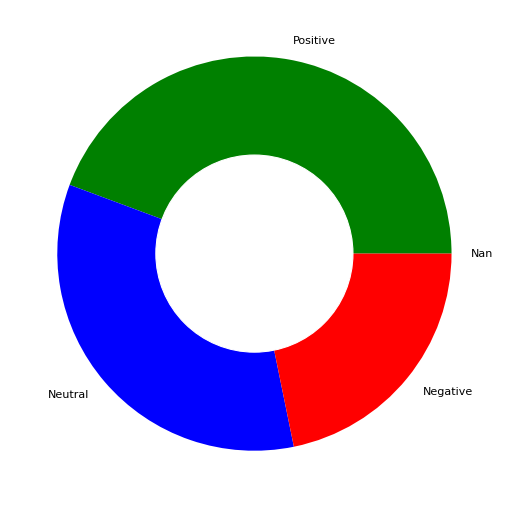

In [8]:
plt.figure(figsize=(13,8), dpi=80)
pichart = count_values_in_column(df,"category")
names =["Positive","Neutral","Negative","Nan"]
size = pichart["Percentage"]

my_circle = plt.Circle((0,0),0.5,color='white')
plt.pie(size,labels=names,colors=['green','blue','red','yellow'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
def create_worldcloud(text,path):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", max_words=3000,stopwords=stopwords,random_state=42,width=900,height=500,repeat=True)
    wc.generate(str(text))
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    path=path
    display(Image.open(path))

Word Cloud Saved Successfully


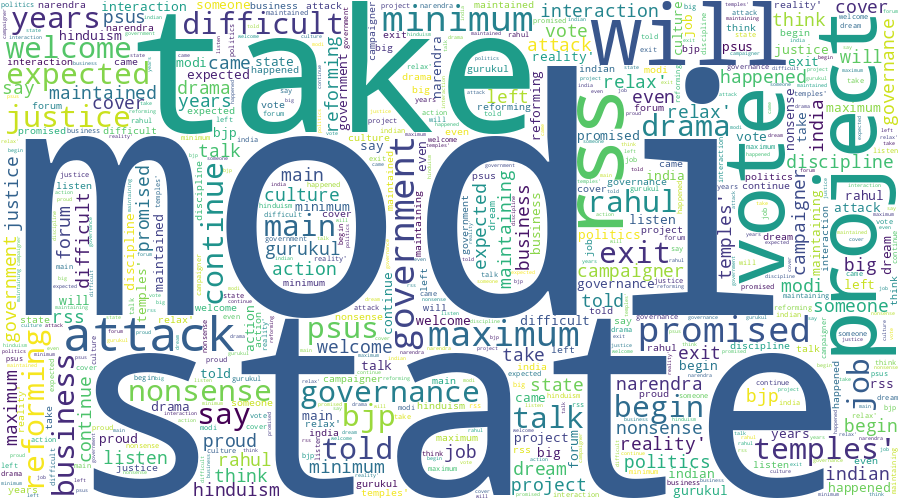

<Figure size 1200x640 with 0 Axes>

In [10]:
plt.figure(figsize=(15,8), dpi=80)
create_worldcloud(df['clean_text'].values,"all.png")

Word Cloud Saved Successfully


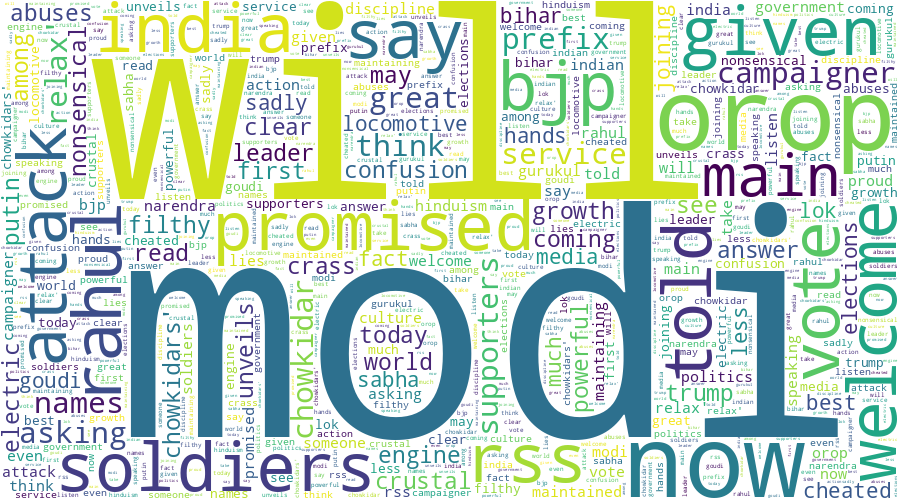

<Figure size 1200x640 with 0 Axes>

In [11]:
plt.figure(figsize=(15, 8), dpi=80)
create_worldcloud(df_positive['clean_text'].values,"positive.png")

Word Cloud Saved Successfully


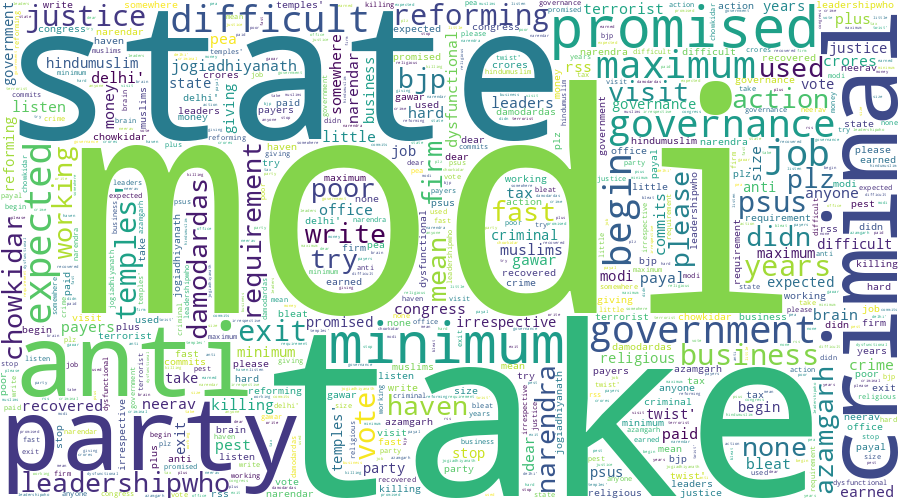

<Figure size 1200x640 with 0 Axes>

In [12]:
plt.figure(figsize=(15,8),dpi=80)
create_worldcloud(df_negative['clean_text'].values,"negative.png")

Word Cloud Saved Successfully


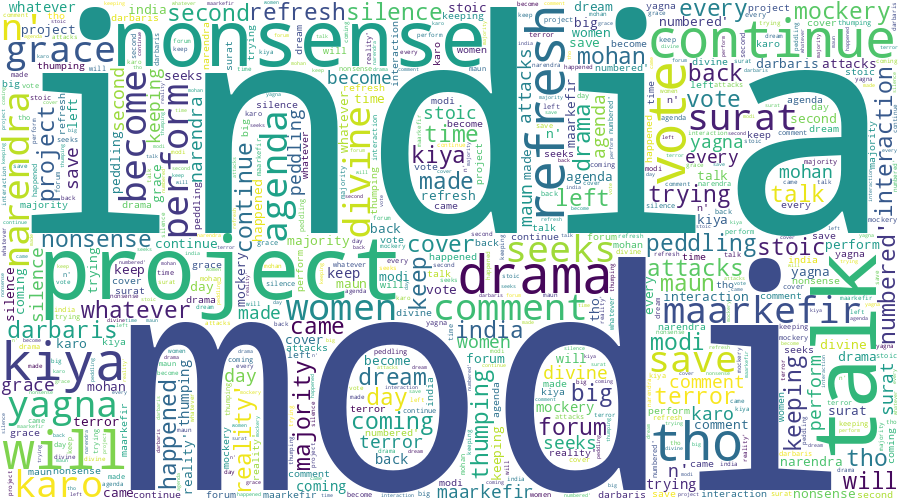

<Figure size 1200x640 with 0 Axes>

In [13]:
plt.figure(figsize=(15,8),dpi=80)
create_worldcloud(df_neutral['clean_text'].values,"neutral.png")

Insights¶

From all these wordclouds of different classes, we can MODI is the common words used </li>

From positive sentiment wordclouds, we can see that WELCOME, SOLDIERS are the most common words used

From negative sentiment wordclouds, we can see that ANTI, CRIMINAL, KILLING are the most common words used

From neutral sentiment wordclouds, we can see that INDIA, PROJECT,CONTINUE are the most common words used
</ul> </font>

In [14]:
ps = PorterStemmer()
corpus = []
words = []
for i in range(0,len(df)):
    review = re.sub('[^a-zA-Z]','',str(df["clean_text"][i]))
    review = review.lower()
    review = review.split()
    stemmed = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ''.join(stemmed)
    corpus.append(review)
    words.append(stemmed)

In [15]:
corpus[1:10]

['talkallthenonsenseandcontinueallthedramawillvoteformodi',
 'whatdidjustsayvoteformodiwelcomebjptoldyourahulthemaincampaignerformodithinkmodishouldjustrelax',
 'askinghissupportersprefixchowkidartheirnamesmodididgreatservicenowthereconfusionwhatreadwhatnotnowcrustalclearwhatwillcrassfilthynonsensicalseehowmostabusesarecomingfromchowkidar',
 'answerwhoamongthesethemostpowerfulworldleadertodaytrumpputinmodimay',
 'kiyathorefreshmaarkefircommentkaro',
 'suratwomenperformyagnaseeksdivinegracefornarendramodibecomeagain',
 'thiscomesfromcabinetwhichhasscholarslikemodismritiandhematimeintrospect',
 'withupcomingelectionindiasagagoingimportantpairlookcurrentmodileadsgovtelectedwithdealbrexitcombinationthisweeklylooksjuicybearsimho',
 'gandhiwasgaydoesmodi']

In [16]:
print("length of Corpus:",len(corpus))

length of Corpus: 162980


In [17]:
df["clean_text"] = corpus

In [18]:
df = df.dropna()
df = df.reset_index()

In [19]:
df.isna().sum()

index         0
clean_text    0
category      0
dtype: int64

In [20]:
df[["clean_text","category"]].to_csv("stemmed.csv",index = False)

In [21]:
df_stemmed = pd.read_csv("stemmed.csv")
corpus = list(df_stemmed["clean_text"])

In [22]:
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(df["clean_text"]).toarray()

In [23]:
X = df_stemmed["clean_text"]
Y = df_stemmed["category"]

In [24]:
df_tfidf = pd.DataFrame(X_tfidf, columns = tfidf.get_feature_names_out())
df_tfidf["output"] = Y
df_tfidf.head()

,aapagarkamalbuttondabaogetovoteseedhamodijayegemodimeerutnowcongresshasfightpresidentialelectionwithbjpkeepingtherefrontfac,aapfilescomplaintwithagainstmodiforviolatingpollcod,aapfilescomplaintwithagainstnarendramodiforviolatingpollcod,aaprunsrepublicmedianetworksinterviewwithmoditunewatcharnabgoswamistakel,aaptargetsmodioversabootsapootspeechhistrademarkstyl,abhinadanbeingpowwasnothumiliatingenoughnowtheworldlaughsindiasairforceforkillingitsownanyoneblamedmoditheonewhoforhisownelectionforcedtheairforcecarryoutmissionwhichwasstrategicallysuicid,abhinandanwouldpayfordestroyingmodisplannedwarequivalentgujarathadeverythingpulwamabodiesparadeandtheensuingwarhadpersonalstakehecknotevenanygujaratistakewithnonethesepatriotsthearmi,abpanandbazaarpatrikaleftistscommunistsfakenewsfakestoriesdenfromwestbengalknowncommunistandantimodifakenewsjourno,acceptingtheentirenationonceagainmodigovern,accordingmodi,...,yourxxxxxcreditedinrdeposittransferfromcongressbalinrlakhmodiwalehain,yourxxxxxcreditedinrdeposittransferfromindiannationalcongressbalinrlakhmodiwalehain,yousaidchoukidarmodichoraaheshahafzalkhanashewaghpillathukhnahichatatahavemodiwhosyourleaderuddhavthackerayblastsoppositionndtv,youthkashmirdisappointedwithmodigovern,youththepowerthecountrybutmodigovernmentonlymadethemjobless,youthwithmodi,youthwithmodivoteandsupportmodiagain,yuplikenasaspacecentrebutmodiwantswintheelectioncananythinkanythinkwintheelect,zindiaelectionmodisaysindianowspacepow,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
X_train_tfidf,X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(X_tfidf, Y,test_size=0.33,random_state = 27)

In [26]:
classfier_tfidf = MultinomialNB(alpha=0.1)
classfier_tfidf.fit(X_train_tfidf,Y_train_tfidf)
Y_pred_tfidf = classfier_tfidf.predict(X_test_tfidf)

In [27]:
logistic_tfidf = LogisticRegression(solver='liblinear')
logistic_tfidf.fit(X_train_tfidf,Y_train_tfidf)
Y_pred_logistic_tfidf = logistic_tfidf.predict(X_test_tfidf)

In [28]:
acc_log_tfidf = accuracy_score(Y_test_tfidf,Y_pred_logistic_tfidf)
classification_log_tfidf = classification_report(Y_test_tfidf,Y_pred_logistic_tfidf)
confusion_matrix_log_tfidf = confusion_matrix(Y_test_tfidf,Y_pred_logistic_tfidf)

In [29]:
print("For Logistic Regression: \n")
print(" \n Accuracy : ",acc_log_tfidf,"\n","Classification report \n",classification_log_tfidf,"\n","Confusion matrix \n",confusion_matrix_log_tfidf)

For Logistic Regression: 

 
 Accuracy :  0.45864787475363505 
 Classification report 
               precision    recall  f1-score   support

        -1.0       1.00      0.01      0.01     11708
         0.0       1.00      0.04      0.08     18192
         1.0       0.45      1.00      0.62     23882

    accuracy                           0.46     53782
   macro avg       0.82      0.35      0.24     53782
weighted avg       0.75      0.46      0.30     53782
 
 Confusion matrix 
 [[   59     1 11648]
 [    0   728 17464]
 [    0     2 23880]]


For Logistic Regression, we get 83% Accuracy with liblinear as a solver>

In [30]:
acc_tfidf = accuracy_score(Y_test_tfidf,Y_pred_tfidf)
classification_tfidf = classification_report(Y_test_tfidf,Y_pred_tfidf)
confusion_matrix_tfidf = confusion_matrix(Y_test_tfidf,Y_pred_tfidf)

In [31]:
print("For Mutinomial Naive Bayes: \n")
print(" \n Accuracy : ",acc_tfidf,"\n","Classification report \n",classification_tfidf,"\n","Confusion matrix \n",confusion_matrix_tfidf)

For Mutinomial Naive Bayes: 

 
 Accuracy :  0.4627570562641776 
 Classification report 
               precision    recall  f1-score   support

        -1.0       0.99      0.02      0.05     11708
         0.0       1.00      0.04      0.08     18192
         1.0       0.45      1.00      0.62     23882

    accuracy                           0.46     53782
   macro avg       0.81      0.35      0.25     53782
weighted avg       0.75      0.46      0.31     53782
 
 Confusion matrix 
 [[  282     1 11425]
 [    0   728 17464]
 [    2     2 23878]]


For Mutinomail NB, we get 70% Accuracy with alpha = 0.1

In [32]:
messages = X.copy()

In [33]:
voc_size = 5000
embedding_vector_features = 200
sent_length = 200
lstm_out = 128

In [34]:
onehot_repr=[one_hot(words,voc_size)for words in df["clean_text"]]
onehot_repr[1:3]

[[2272], [4645]]

In [35]:
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[ 432    0    0 ...    0    0    0]
 [2272    0    0 ...    0    0    0]
 [4645    0    0 ...    0    0    0]
 ...
 [4675    0    0 ...    0    0    0]
 [1736    0    0 ...    0    0    0]
 [4612    0    0 ...    0    0    0]]


In [36]:
Y = [2 if x == -1 else x for x in Y]

X_final=np.array(embedded_docs)
y_final=np.array(Y)

In [37]:
X_final.shape,y_final.shape

((162973, 200), (162973,))

In [38]:
X_train_embed, X_test_embed, Y_train_embed, Y_test_embed = train_test_split(X_final, y_final, test_size=0.33, random_state=27)

In [39]:
model = Sequential()

model.add(Input(shape=(None,)))

model.add(Embedding(voc_size, embedding_vector_features))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.2)))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 200)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,243 (5.26 MB)

 Trainable params: 1,378,243 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train_embed,Y_train_embed,validation_data=(X_test_embed,Y_test_embed),
                    epochs=2, batch_size=256,
                    verbose=1,shuffle=True)

Epoch 1/2
427/427 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.4372 - loss: 1.0640 - val_accuracy: 0.4441 - val_loss: 1.0593
Epoch 2/2
427/427 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.4444 - loss: 1.0556 - val_accuracy: 0.4438 - val_loss: 1.0609


In [41]:
predictions = model.predict(X_test_embed)
print(history.history)

1681/1681 ━━━━━━━━━━━━━━━━━━━━ 173s 102ms/step
{'accuracy': [0.4422617256641388, 0.4431042969226837], 'loss': [1.0615265369415283, 1.05641770362854], 'val_accuracy': [0.44405192136764526, 0.44379159808158875], 'val_loss': [1.0593087673187256, 1.0608999729156494]}
